<font size='12'><center>
    Unsupervised learning on bilateral trade data
</font></center>

# Preamble

In [1]:
%%bash
pip install -q pyreadr

In [2]:
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
# For offline rendering in JupyterLab
alt.renderers.enable('default')
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA

# Data wrangling

## Mis-invoiced trade data (for African reporting countries)

In [3]:
panel = pyreadr.read_r('Data/GER_Orig_Sect_Year_Africa.Rdata')
IFF_Sector = panel['GER_Orig_Sect_Year_Africa']

In [4]:
obs_info = IFF_Sector.reset_index().drop_duplicates(['reporter.ISO', 'year'])[['reporter.ISO', 
                                                                               'year', 
                                                                               'reporter', 
                                                                               'rIncome', 
                                                                               'rDev']]
obs_info = obs_info.replace({'LIC': 'Low income', 
                             'LMC': 'Lower-middle income',
                             'UMC': 'Upper-middle income',
                             'HIC': 'High income'})
obs_info = obs_info.rename(columns={'rIncome': 'Income group (World Bank)', 
                                    'rDev': 'Country status (UN)'})

In [5]:
IFF_Sector = IFF_Sector.fillna(0).drop(columns=['reporter', 'rIncome', 'rDev', 'section.code',
                                                'Imp_IFF_lo', 'Exp_IFF_lo']) \
            .set_index(['reporter.ISO', 'year'])

IFF_Sector_mean = IFF_Sector.reset_index().groupby(['reporter.ISO', 'section']).mean(). \
    reset_index().set_index('reporter.ISO')
IFF_Sector_log = IFF_Sector.apply(lambda x: np.log(x+1) if np.issubdtype(x.dtype, np.number) else x)

In [6]:
IFF_Sector_Imp = IFF_Sector[['section', 'Imp_IFF_hi']]
IFF_Sector_Exp = IFF_Sector[['section', 'Exp_IFF_hi']]
# IFF_Sector_Imp

## Mis-invoiced trade data (bilateral trade matrix)

In [7]:
panel = pyreadr.read_r('Data/GER_Orig_Dest_Year_Africa.Rdata')
IFF_Dest = panel['GER_Orig_Dest_Year_Africa']

In [8]:
IFF_Dest = IFF_Dest.fillna(0).drop(columns=['reporter', 'rIncome', 'rDev', 
                                            'partner', 'pRegion', 'pIncome', 'pDev',
                                            'Imp_IFF_lo', 'Exp_IFF_lo']) \
            .set_index(['reporter.ISO', 'year'])

IFF_Dest_mean = IFF_Dest.reset_index().groupby(['reporter.ISO', 'partner.ISO']).mean(). \
    reset_index().set_index('reporter.ISO')
IFF_Dest_log = IFF_Dest.apply(lambda x: np.log(x+1) if np.issubdtype(x.dtype, np.number) else x)

In [9]:
IFF_Dest_Imp = IFF_Dest[['partner.ISO', 'Imp_IFF_hi']]
IFF_Dest_Exp = IFF_Dest[['partner.ISO', 'Exp_IFF_hi']]
# IFF_Dest_Imp

### Crosswalk data

In [10]:
! wget -qO Data/crosswalk.xlsx https://github.com/walice/Codes-Masterlist/blob/master/Codes_Masterlist.xlsx?raw=true

In [11]:
crosswalk = pd.read_excel("Data/crosswalk.xlsx").rename(columns={'Country': 'country'})
# crosswalk.head()

# Auxiliary Functions

In [12]:
def create_features(data, values, features, obs):
    """
    TODO: add doc string
    """
    features_data = data.pivot_table(values=values, 
                                     columns=features, 
                                     index=[obs, 'year'], 
                                     fill_value=0)
    return features_data

In [13]:
def create_features_mean(data, values, features, obs):
    """
    TODO: add doc string
    """
    features_data = data.pivot_table(values=values, 
                                     columns=features, 
                                     index=obs, 
                                     fill_value=0)
    return features_data

In [14]:
def biplot_PCA(features_data, nPC=2, firstPC=1, secondPC=2, obs='reporter.ISO', show_loadings=False):
    """Projects the data in the 2-dimensional space spanned by 2 principal components
    chosen by the user, along with a bi-plot of the top 3 loadings per PC, and colors
    by class label.

    Args:
        features_data: data-set of features
        nPC: number of principal components
        firstPC: integer denoting first principal component to plot in bi-plot
        secondPC: integer denoting second principal component to plot in bi-plot
        obs: string denoting index of class labels (in features_data)
        show_loadings: Boolean indicating whether PCA loadings should be displayed
    Returns:
        plot (static)
        pca_loadings (if show_loadings=True)
    """
        
    # Run PCA (standardize data beforehand)
    features_data_std = StandardScaler().fit_transform(features_data)
    pca = PCA(n_components=nPC)
    princ_comp = pca.fit_transform(features_data_std)

    # Extract PCA loadings
    cols = ['PC' + str(c+1) for c in np.arange(nPC)]
    pca_loadings = pd.DataFrame(pca.components_.T, 
                                columns=cols,
                                index=list(features_data.columns))
   
    # Extract PCA scores
    pca_scores = pd.DataFrame(princ_comp, 
                              columns=cols)
    pca_scores[obs] = features_data.reset_index()[obs].values.tolist()
    pca_scores['year'] = features_data.reset_index()['year'].values.tolist()
    
    score_PC1 = princ_comp[:,firstPC-1]
    score_PC2 = princ_comp[:,secondPC-1]
    
    # Generate plot data
    if obs == 'reporter.ISO':
        plot_data = pd.merge(pca_scores, obs_info, on=[obs, 'year'])
        color_obs = 'reporter'
        tooltip_obs = ['reporter', 'year', 'Income group (World Bank)', 'Country status (UN)']
    else:
        plot_data = pca_scores
        color_obs = 'section'
        tooltip_obs = ['section', 'year']

    # Return chosen PCs to plot
    PC1 = 'PC'+str(firstPC)
    PC2 = 'PC'+str(secondPC)

    # Extract top loadings (in absolute value)
    # TO DO: use dict to iterate over
    toploadings_PC1 = pca_loadings.apply(lambda x: abs(x)).sort_values(by=PC1).tail(3)[[PC1, PC2]]
    toploadings_PC2 = pca_loadings.apply(lambda x: abs(x)).sort_values(by=PC2).tail(3)[[PC1, PC2]]

    originsPC1 = pd.DataFrame({'index':toploadings_PC1.index.tolist(), 
                               PC1: np.zeros(3), 
                               PC2:np.zeros(3)})
    originsPC2 = pd.DataFrame({'index':toploadings_PC2.index.tolist(), 
                               PC1: np.zeros(3), 
                               PC2:np.zeros(3)})
    
    toploadings_PC1 = pd.concat([toploadings_PC1.reset_index(), originsPC1], axis=0)
    toploadings_PC2 = pd.concat([toploadings_PC2.reset_index(), originsPC2], axis=0)

    toploadings_PC1[PC1] = toploadings_PC1[PC1]*max(score_PC1)*1.5
    toploadings_PC1[PC2] = toploadings_PC1[PC2]*max(score_PC2)*1.5
    toploadings_PC2[PC1] = toploadings_PC2[PC1]*max(score_PC1)*1.5
    toploadings_PC2[PC2] = toploadings_PC2[PC2]*max(score_PC2)*1.5
    
    # Project top 3 loadings over the space spanned by 2 principal components
    lines = alt.Chart().mark_line().encode()
    for color, i, dataset in zip(['#440154FF', '#21908CFF'], [0,1], [toploadings_PC1, toploadings_PC2]):
        lines[i] = alt.Chart(dataset).mark_line(color=color).encode(
        x= PC1 +':Q',
        y= PC2 +':Q',
        detail='index'
    ).properties(
        width=500,
        height=500
    )
    
    # Add labels to the loadings
    text=alt.Chart().mark_text().encode()
    for color, i, dataset in zip(['#440154FF', '#21908CFF'], [0, 1], [toploadings_PC1[0:3], toploadings_PC2[0:3]]):
        text[i] = alt.Chart(dataset).mark_text(
                align='left',
                baseline='bottom',
                color=color
            ).encode(
                x= PC1 +':Q',
                y= PC2 +':Q',
                text='index'
            )
    
    # Scatter plot colored by observation class label
    points = alt.Chart(plot_data).mark_circle(size=60).encode(
        x=alt.X(PC1, axis=alt.Axis(title='Principal Component ' + str(firstPC))),
        y=alt.X(PC2, axis=alt.Axis(title='Principal Component ' + str(secondPC))),
        color=alt.Color(color_obs, scale=alt.Scale(scheme='category20b'),
                       legend=alt.Legend(orient='right')),
        tooltip=tooltip_obs
    ).interactive()
    
    # Bind it all together
    chart = (points + lines[0] + lines[1] + text[0] + text[1])    
    chart.display()

#     if show_loadings:
#         return pca_loadings

In [15]:
def scree_plot(features_data, show_explained_var=False):
    """
    TODO: add comments and docstring
    """
    
    features_data_std = StandardScaler().fit_transform(features_data)
    pca = PCA(n_components=features_data_std.shape[1])
    princ_comp = pca.fit_transform(features_data_std)
    
    explained_var = pd.DataFrame({'PC': np.arange(1,features_data_std.shape[1]+1),
                                  'var': pca.explained_variance_ratio_,
                                  'cumvar': np.cumsum(pca.explained_variance_ratio_)})

    # Adapted from https://altair-viz.github.io/gallery/multiline_tooltip.html
    # Create a selection that chooses the nearest point & selects based on x-value
    nearest = alt.selection(type='single', nearest=True, on='mouseover',
                            fields=['PC'], empty='none')

    # The basic line
    line = alt.Chart(explained_var).mark_line(interpolate='basis', color='#FDE725FF').encode(
        alt.X('PC:Q',
            scale=alt.Scale(domain=(1, len(explained_var))),
            axis=alt.Axis(title='Principal Component')
        ),
        alt.Y('cumvar:Q',
            scale=alt.Scale(domain=(min(explained_var['cumvar']), 1)),
            axis=alt.Axis(title='Cumulative Variance Explained')
        ),
    )

    # Transparent selectors across the chart. This is what tells us
    # the x-value of the cursor
    selectors = alt.Chart(explained_var).mark_point().encode(
        x='PC:Q',
        opacity=alt.value(0),
    ).add_selection(
        nearest
    )

    # Draw points on the line, and highlight based on selection
    points = line.mark_point().encode(
        opacity=alt.condition(nearest, alt.value(1), alt.value(0))
    )

    # Draw text labels near the points, and highlight based on selection
    text = line.mark_text(align='left', dx=5, dy=-5).encode(
        text=alt.condition(nearest, 'cumvar:Q', alt.value(' '))
    )

    # Draw a rule at the location of the selection
    rules = alt.Chart(explained_var).mark_rule(color='gray').encode(
        x='PC:Q',
    ).transform_filter(
        nearest
    )

    # Put the five layers into a chart and bind the data
    out = alt.layer(
        line, selectors, points, rules, text
    ).properties(
        title='Cumulative scree plot',
        width=600, height=300
    )
    
    out.display()
    
    if show_explained_var:
        return explained_var[['PC', 'var']]

# PCA on feature space (for individual reporting countries)

## Sector features

In [16]:
sector_features = create_features(IFF_Sector_Imp, 'Imp_IFF_hi', 
                                  features='section', obs='reporter.ISO')
# sector_features

In [17]:
# biplot_PCA(sector_features, 10, 1, 2, obs='reporter.ISO', show_loadings=True)
biplot_PCA(sector_features, 10, 1, 2, obs='reporter.ISO')

alt.LayerChart(...)

In [18]:
biplot_PCA(sector_features, 10, 3, 4, obs='reporter.ISO')

alt.LayerChart(...)

In [19]:
biplot_PCA(sector_features, 10, 5, 6, obs='reporter.ISO')

alt.LayerChart(...)

In [20]:
# scree_plot(sector_features, show_explained_var=True)
scree_plot(sector_features)

alt.LayerChart(...)

## Country features

In [21]:
country_features = create_features(IFF_Sector_Imp, 'Imp_IFF_hi',
                                   features='reporter.ISO', obs='section')
# country_features

In [22]:
# biplot_PCA(country_features, 10, 1, 2, obs='section', show_loadings=True)
biplot_PCA(country_features, 10, 1, 2, obs='section')

alt.LayerChart(...)

In [23]:
biplot_PCA(country_features, 10, 3, 4, obs='section')

alt.LayerChart(...)

In [24]:
biplot_PCA(country_features, 10, 5, 6, obs='section')

alt.LayerChart(...)

In [25]:
scree_plot(country_features)

alt.LayerChart(...)

# PCA on bilateral trade matrix

In [26]:
partner_features = create_features(IFF_Dest_Imp, 'Imp_IFF_hi', 
                                   features='partner.ISO', obs='reporter.ISO')
# partner_features

In [27]:
# biplot_PCA(partner_features, 10, 1, 2, show_loadings=True)
biplot_PCA(partner_features, 10, 1, 2)

alt.LayerChart(...)

In [28]:
biplot_PCA(partner_features, 10, 3, 4)

alt.LayerChart(...)

In [29]:
biplot_PCA(partner_features, 10, 5, 6)

alt.LayerChart(...)

In [30]:
scree_plot(partner_features)

alt.LayerChart(...)

# Intra-African illicit financial flows

## Data wrangling

In [31]:
panel = pyreadr.read_r('Data/GER_Orig_Dest_Year_Africa.Rdata')
IFF_Dest = panel['GER_Orig_Dest_Year_Africa']
IFF_Dest_AFR = IFF_Dest[IFF_Dest['pRegion'] == 'Africa']

In [32]:
IFF_Dest_AFR = IFF_Dest_AFR.fillna(0).drop(columns=['reporter', 'rIncome', 'rDev', 
                                                    'partner', 'pRegion', 'pIncome', 'pDev',
                                                    'Imp_IFF_lo', 'Exp_IFF_lo']) \
            .set_index(['reporter.ISO', 'year'])

IFF_Dest_Imp_AFR = IFF_Dest_AFR[['partner.ISO', 'Imp_IFF_hi']]
IFF_Dest_Exp_AFR = IFF_Dest_AFR[['partner.ISO', 'Exp_IFF_hi']]
IFF_Dest_Imp_AFR

partner.ISO    Imp_IFF_hi
reporter.ISO year                          
DZA          2001         CIV  4.518475e+07
             2001         EGY  7.978706e+06
             2001         ETH  6.219829e+05
             2001         KEN  8.104818e+03
             2001         ZAF  2.867019e+06
...                       ...           ...
ZWE          2013         NGA  0.000000e+00
             2013         TZA  0.000000e+00
             2014         EGY  0.000000e+00
             2014         MDG  0.000000e+00
             2015         UGA  0.000000e+00

[8260 rows x 2 columns]

In [33]:
partner_features_AFR = create_features(IFF_Dest_Imp_AFR, 'Imp_IFF_hi', 
                                       features='partner.ISO', obs='reporter.ISO')
partner_features_AFR

partner.ISO        AGO  BDI  BEN  BFA           BWA  CAF           CIV  \
reporter.ISO year                                                        
AGO          2009  0.0  0.0  0.0  0.0  0.000000e+00  0.0  7.356525e+05   
             2010  0.0  0.0  0.0  0.0  2.025235e+05  0.0  5.577699e+07   
             2011  0.0  0.0  0.0  0.0  5.501246e+03  0.0  6.262938e+06   
             2012  0.0  0.0  0.0  0.0  0.000000e+00  0.0  1.425377e+07   
             2013  0.0  0.0  0.0  0.0  2.945193e+05  0.0  2.125395e+06   
...                ...  ...  ...  ...           ...  ...           ...   
ZWE          2011  0.0  0.0  0.0  0.0  8.741233e+07  0.0  0.000000e+00   
             2012  0.0  0.0  0.0  0.0  3.187848e+07  0.0  0.000000e+00   
             2013  0.0  0.0  0.0  0.0  0.000000e+00  0.0  0.000000e+00   
             2014  0.0  0.0  0.0  0.0  0.000000e+00  0.0  0.000000e+00   
             2015  0.0  0.0  0.0  0.0  8.142369e+06  0.0  0.000000e+00   

partner.ISO                  CMR           COG  COM  ...          STP  SWZ  \
reporter.ISO year                                    ...                     
AGO          2009       0.000000  0.000000e+00  0.0  ...     0.000000  0.0   
             2010   53088.378146  1.402793e+08  0.0  ...     0.000000  0.0   
             2011  257786.746458  3.466061e+07  0.0  ...     0.000000  0.0   
             2012  222663.224270  2.587614e+07  0.0  ...  8435.069683  0.0   
             2013       0.000000  4.357466e+06  0.0  ...   957.605075  0.0   
...                          ...           ...  ...  ...          ...  ...   
ZWE          2011       0.000000  0.000000e+00  0.0  ...     0.000000  0.0   
             2012       0.000000  0.000000e+00  0.0  ...     0.000000  0.0   
             2013       0.000000  0.000000e+00  0.0  ...     0.000000  0.0   
             2014       0.000000  0.000000e+00  0.0  ...     0.000000  0.0   
             2015       0.000000  0.000000e+00  0.0  ...     0.000000  0.0   

partner.ISO        SYC            TGO           TUN           TZA  UGA  \
reporter.ISO year                                                        
AGO          2009  0.0       0.000000  1.628157e+06  0.000000e+00  0.0   
             2010  0.0  252999.300576  1.137066e+08  5.529461e+03  0.0   
             2011  0.0       0.000000  4.623718e+07  1.745372e+06  0.0   
             2012  0.0       0.000000  1.262796e+07  1.253616e+05  0.0   
             2013  0.0       0.000000  4.438123e+06  1.035603e+05  0.0   
...                ...            ...           ...           ...  ...   
ZWE          2011  0.0       0.000000  0.000000e+00  1.295280e+06  0.0   
             2012  0.0       0.000000  0.000000e+00  2.729399e+06  0.0   
             2013  0.0       0.000000  0.000000e+00  0.000000e+00  0.0   
             2014  0.0       0.000000  0.000000e+00  0.000000e+00  0.0   
             2015  0.0       0.000000  0.000000e+00  8.238550e+06  0.0   

partner.ISO                 ZAF           ZMB            ZWE  
reporter.ISO year                                             
AGO          2009  1.016827e+09  1.060946e+05  309894.487818  
             2010  3.315930e+08  2.665205e+04  420951.156359  
             2011  3.281534e+08  4.525653e+05       0.000000  
             2012  7.944924e+08  1.180964e+03       0.000000  
             2013  4.272753e+08  2.855892e+05       0.000000  
...                         ...           ...            ...  
ZWE          2011  3.088036e+09  5.016118e+07       0.000000  
             2012  1.242790e+09  1.704507e+08       0.000000  
             2013  0.000000e+00  0.000000e+00       0.000000  
             2014  0.000000e+00  0.000000e+00       0.000000  
             2015  6.474374e+08  0.000000e+00       0.000000  

[604 rows x 46 columns]

In [34]:
partner_features_AFR = pd.merge(left=partner_features_AFR.reset_index(), 
                                right=crosswalk[['ISO3166.3', 'UN_Intermediate_Region']].drop_duplicates('ISO3166.3'), 
                                how='left', 
                                left_on='reporter.ISO', right_on='ISO3166.3')
partner_features_AFR
# KEEP THIS NARRATIVE TO EXPLAIN FUNCTION
noregion_mask = partner_features_AFR['UN_Intermediate_Region'].isnull()
countries_noregion = partner_features_AFR[noregion_mask]['reporter.ISO'].unique().tolist()
countries_noregion

['DZA', 'EGY', 'LBY', 'MAR', 'SDN', 'TUN']

In [35]:
crosswalk[crosswalk['ISO3166.3'].isin(countries_noregion)]['UN_Sub-region'].unique()

array(['Northern Africa'], dtype=object)

In [36]:
partner_features_AFR.loc[partner_features_AFR['reporter.ISO'].isin(countries_noregion), 'UN_Intermediate_Region'] = 'Northern Africa'

# region_labels = partner_features_AFR.reset_index().set_index('UN_Intermediate_Region').index.tolist()
partner_features_AFR = partner_features_AFR.set_index(['reporter.ISO', 'year']).drop(columns=['ISO3166.3', 'UN_Intermediate_Region'])
# region_labels

In [37]:
#biplot_PCA(partner_features, partner_features.shape[1], partner_features.shape[1]-1, partner_features.shape[1])
biplot_PCA(partner_features_AFR, partner_features_AFR.shape[1], 1, 2)

alt.LayerChart(...)

## Remove outliers

In [38]:
features_data_std = StandardScaler().fit_transform(partner_features_AFR)
pca = PCA(n_components=partner_features_AFR.shape[1])
princ_comp = pca.fit_transform(features_data_std)
#outlying = (princ_comp[:,44] > 1.5) | (princ_comp[:,45] > 3e-15)
#outlying = (princ_comp[:,44] > 0.5) | (princ_comp[:,45] > 1.5e-15)
outlying = (princ_comp[:,0] > 6) | (princ_comp[:,1] > 4)
partner_features_AFR[outlying].index

MultiIndex([('AGO', '2010'),
            ('CIV', '2013'),
            ('EGY', '2012'),
            ('GHA', '2002'),
            ('MAR', '2005'),
            ('MAR', '2006'),
            ('MAR', '2007'),
            ('MAR', '2008'),
            ('MAR', '2009'),
            ('MAR', '2010'),
            ('MAR', '2011'),
            ('MAR', '2012'),
            ('NGA', '2011'),
            ('ZAF', '2005'),
            ('ZAF', '2006'),
            ('ZAF', '2008'),
            ('ZAF', '2010'),
            ('ZAF', '2011'),
            ('ZAF', '2012'),
            ('ZAF', '2013'),
            ('ZAF', '2014'),
            ('ZAF', '2015'),
            ('ZAF', '2016')],
           names=['reporter.ISO', 'year'])

In [39]:
partner_features_AFR_noout = partner_features_AFR[~outlying]

In [40]:
biplot_PCA(partner_features_AFR_noout, 46, 1, 2)

alt.LayerChart(...)

## Coloring by class label

In [41]:
def region_labels(features_data):
    """
    TODO: add doc string
    """
    # Extract observation labels from features data
    obs_labels = pd.DataFrame(features_data.reset_index().set_index('reporter.ISO').index)

    # Merge with UN intermediate regions from crosswalk
    obs_labels = pd.merge(left=obs_labels,
                          right=crosswalk[['ISO3166.3', 'UN_Intermediate_Region']].drop_duplicates('ISO3166.3'), 
                          how='left', 
                          left_on='reporter.ISO', right_on='ISO3166.3') \
    .drop(columns='ISO3166.3')

    # Create a mask for the Northern African regions and replace the missing intermediate region
    noregion_mask = obs_labels['UN_Intermediate_Region'].isnull()
    countries_noregion = obs_labels[noregion_mask]['reporter.ISO'].unique().tolist()
    obs_labels.loc[obs_labels['reporter.ISO'].isin(countries_noregion), 'UN_Intermediate_Region'] = 'Northern Africa'

    return obs_labels

In [42]:
def biplot_PCA_classes(features_data, nPC=2, firstPC=1, secondPC=2, classes='UN_Intermediate_Region'):
    """
    TODO: update docstring
    Projects the data in the 2-dimensional space spanned by 2 principal components
    chosen by the user, along with a bi-plot of the top 3 loadings per PC, and colors
    by class label.

    Args:
        features_data: data-set of features
        nPC: number of principal components
        firstPC: integer denoting first principal component to plot in bi-plot
        secondPC: integer denoting second principal component to plot in bi-plot
        obs: string denoting index of class labels (in features_data)
        show_loadings: Boolean indicating whether PCA loadings should be displayed
    Returns:
        plot (static)
        pca_loadings (if show_loadings=True)
    """
    
    # Unit of observation is the reporting country
    obs='reporter.ISO'
    
    # Run PCA (standardize beforehand)
    features_data_std = StandardScaler().fit_transform(features_data)
    pca = PCA(n_components=nPC)
    princ_comp = pca.fit_transform(features_data_std)

    # Loadings
    cols = ['PC' + str(c+1) for c in np.arange(nPC)]
    pca_loadings = pd.DataFrame(pca.components_.T, 
                                columns=cols,
                                index=list(features_data.columns))
   
    # Scores
    pca_scores = pd.DataFrame(princ_comp, 
                              columns=cols)
    pca_scores[obs] = features_data.reset_index()[obs].values.tolist()
    pca_scores['year'] = features_data.reset_index()['year'].values.tolist()
    
    score_PC1 = princ_comp[:,firstPC-1]
    score_PC2 = princ_comp[:,secondPC-1]
    
    # Plot data
    plot_data = pd.merge(pca_scores, obs_info, on=[obs, 'year'])
    tooltip_obs = ['reporter', 'year', 'Income group (World Bank)', 'Country status (UN)']
    
    obs_labels = region_labels(features_data)
    plot_data = pd.merge(left=plot_data, right=obs_labels.drop_duplicates('reporter.ISO'), on='reporter.ISO')
    
    if classes == 'UN_Intermediate_Region':
        color_scheme = 'paired'
    else:
        color_scheme = 'dark2'

    # Return chosen PCs to plot
    PC1 = 'PC'+str(firstPC)
    PC2 = 'PC'+str(secondPC)
    
    # Top loadings (in absolute value)
    # TO DO: use dict to iterate over
    toploadings_PC1 = pca_loadings.apply(lambda x: abs(x)).sort_values(by=PC1).tail(3)[[PC1, PC2]]
    toploadings_PC2 = pca_loadings.apply(lambda x: abs(x)).sort_values(by=PC2).tail(3)[[PC1, PC2]]

    originsPC1 = pd.DataFrame({'index':toploadings_PC1.index.tolist(), 
                               PC1: np.zeros(3), 
                               PC2:np.zeros(3)})
    originsPC2 = pd.DataFrame({'index':toploadings_PC2.index.tolist(), 
                               PC1: np.zeros(3), 
                               PC2:np.zeros(3)})
    
    toploadings_PC1 = pd.concat([toploadings_PC1.reset_index(), originsPC1], axis=0)
    toploadings_PC2 = pd.concat([toploadings_PC2.reset_index(), originsPC2], axis=0)

    toploadings_PC1[PC1] = toploadings_PC1[PC1]*max(score_PC1)*1.5
    toploadings_PC1[PC2] = toploadings_PC1[PC2]*max(score_PC2)*1.5
    toploadings_PC2[PC1] = toploadings_PC2[PC1]*max(score_PC1)*1.5
    toploadings_PC2[PC2] = toploadings_PC2[PC2]*max(score_PC2)*1.5
    
    # Project top 3 loadings over the space spanned by 2 principal components
    lines = alt.Chart().mark_line().encode()
    for color, i, dataset in zip(['#440154FF', '#21908CFF'], [0,1], [toploadings_PC1, toploadings_PC2]):
        lines[i] = alt.Chart(dataset).mark_line(color=color).encode(
        x= PC1 +':Q',
        y= PC2 +':Q',
        detail='index'
    ).properties(
        width=500,
        height=500
    )
    
    # Add labels to the loadings
    text=alt.Chart().mark_text().encode()
    for color, i, dataset in zip(['#440154FF', '#21908CFF'], [0, 1], [toploadings_PC1[0:3], toploadings_PC2[0:3]]):
        text[i] = alt.Chart(dataset).mark_text(
                align='left',
                baseline='bottom',
                color=color
            ).encode(
                x= PC1 +':Q',
                y= PC2 +':Q',
                text='index'
            )
    
    # Scatter plot colored by observation class label
    points = alt.Chart(plot_data).mark_circle(size=60).encode(
        x=alt.X(PC1, axis=alt.Axis(title='Principal Component ' + str(firstPC))),
        y=alt.X(PC2, axis=alt.Axis(title='Principal Component ' + str(secondPC))),
        color=alt.Color(classes, scale=alt.Scale(scheme=color_scheme),
               legend=alt.Legend(orient='right')),
        tooltip=tooltip_obs
    ).interactive()
    
    chart = (points + lines[0] + lines[1] + text[0] + text[1])    
    chart.display()

In [43]:
biplot_PCA_classes(sector_features, 6, 1, 2, classes='UN_Intermediate_Region')

alt.LayerChart(...)

In [44]:
biplot_PCA_classes(sector_features, 6, 1, 2, classes='Income group (World Bank)')

alt.LayerChart(...)

In [45]:
biplot_PCA_classes(partner_features, 6, 1, 2)

alt.LayerChart(...)

In [46]:
biplot_PCA_classes(partner_features, 6, 1, 2, classes='Income group (World Bank)')

alt.LayerChart(...)

In [47]:
biplot_PCA_classes(partner_features_AFR, 6, 1, 2)

alt.LayerChart(...)

In [48]:
biplot_PCA_classes(partner_features_AFR, 6, 1, 2, classes='Income group (World Bank)')

alt.LayerChart(...)

In [49]:
biplot_PCA_classes(partner_features_AFR_noout, 6, 1, 2)

alt.LayerChart(...)

In [50]:
biplot_PCA_classes(partner_features_AFR_noout, 6, 1, 2, classes='Income group (World Bank)')

alt.LayerChart(...)

# Clustering

In [51]:
# print(__doc__)

# import numpy as np

# from sklearn.cluster import DBSCAN
# from sklearn import metrics
# from sklearn.datasets import make_blobs
# from sklearn.preprocessing import StandardScaler


# # #############################################################################
# # Generate sample data
# centers = [[1, 1], [-1, -1], [1, -1]]
# X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
#                             random_state=0)

# X = StandardScaler().fit_transform(X)

# # #############################################################################
# # Compute DBSCAN
# db = DBSCAN(eps=0.3, min_samples=10).fit(X)
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
# labels = db.labels_

# # Number of clusters in labels, ignoring noise if present.
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise_ = list(labels).count(-1)

# print('Estimated number of clusters: %d' % n_clusters_)
# print('Estimated number of noise points: %d' % n_noise_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, labels))

# # #############################################################################
# # Plot result
# import matplotlib.pyplot as plt

# # Black removed and is used for noise instead.
# unique_labels = set(labels)
# colors = [plt.cm.Spectral(each)
#           for each in np.linspace(0, 1, len(unique_labels))]
# for k, col in zip(unique_labels, colors):
#     if k == -1:
#         # Black used for noise.
#         col = [0, 0, 0, 1]

#     class_member_mask = (labels == k)

#     xy = X[class_member_mask & core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=14)

#     xy = X[class_member_mask & ~core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=6)

# plt.title('Estimated number of clusters: %d' % n_clusters_)
# plt.show()

Estimated number of clusters: 2


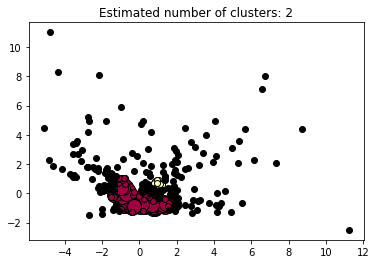

In [52]:
from sklearn.cluster import DBSCAN

features_data_std = StandardScaler().fit_transform(partner_features_AFR_noout)
pca = PCA(n_components=10)
princ_comp = pca.fit_transform(features_data_std)
X = princ_comp[:,[0,1]]
    
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
# print('Estimated number of noise points: %d' % n_noise_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

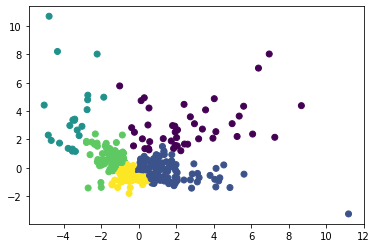

In [53]:
features_data_std = StandardScaler().fit_transform(partner_features_AFR_noout)
pca = PCA(n_components=10)
princ_comp = pca.fit_transform(features_data_std)
X = princ_comp[:,[0,1]]

from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=5).fit(X)
clustering.labels_
plt.scatter(X[:, 0], X[:, 1], c=clustering.labels_);

# Extra stuff (archive)

In [54]:
# cols = ['PC' + str(c+1) for c in np.arange(nPC)]
# pca_scores = pd.DataFrame(princ_comp,
#                           columns=cols,
#                           index=target,)
# pca_scores['class'] = target

# sns.lmplot(x='PC1', 
#            y='PC2', 
#            data=pca_scores, fit_reg=False, hue='class');

In [55]:
# plt.figure()
# lw = 2

# for i, target_name in zip(list(rng), target_names):
#     plt.scatter(princ_comp[y == i, 0], princ_comp[y == i, 1], 
#                 alpha=.8, lw=lw,
#                 label=target_name)
# plt.legend(loc='best', shadow=False, scatterpoints=1)
# plt.title('PCA of trade dataset');

In [56]:
# DO NOT MODIFY
def biplot_PCA_static(features_data, nPC=2, firstPC=1, secondPC=2, obs='reporter.ISO', show_loadings=False):
    """Projects the data in the 2-dimensional space spanned by 2 principal components
    chosen by the user, along with a bi-plot of the top 3 loadings per PC, and colors
    by class label.
    
    Args:
        features_data: data-set of features
        nPC: number of principal components
        firstPC: integer denoting first principal component to plot in bi-plot
        secondPC: integer denoting second principal component to plot in bi-plot
        obs: string denoting index of class labels (in features_data)
        show_loadings: Boolean indicating whether PCA loadings should be displayed
    Returns:
        plot (static)
        pca_loadings (if show_loadings=True)
    """
    
    # Run PCA (standardize beforehand)
    features_data_std = StandardScaler().fit_transform(features_data)
    pca = PCA(n_components=nPC)
    princ_comp = pca.fit_transform(features_data_std)

    # Loadings
    cols = ['PC' + str(c+1) for c in np.arange(nPC)]
    pca_loadings = pd.DataFrame(pca.components_.T, 
                                columns=cols,
                                index=list(features_data.columns))

    # Scores
    score_PC1 = princ_comp[:,firstPC-1]
    score_PC2 = princ_comp[:,secondPC-1]
    
    pca_scores = pd.DataFrame(princ_comp, 
                              columns=cols)
    
    # Return chosen PCs to plot
    PC1 = 'PC'+str(firstPC)
    PC2 = 'PC'+str(secondPC)

    # Top loadings (in absolute value)
#     toploadings_PC1 = pca_loadings.nlargest(3, PC1)
#     toploadings_PC2 = pca_loadings.nlargest(3, PC2)
    toploadings_PC1 = pca_loadings.apply(lambda x: abs(x)).sort_values(by=PC1).tail(3)
    toploadings_PC2 = pca_loadings.apply(lambda x: abs(x)).sort_values(by=PC2).tail(3)

    # Plot bi-plot
    plt.figure(figsize=(10,10))
    for i in range(toploadings_PC1.shape[0]):
        plt.arrow(0, 0, 
                  toploadings_PC1[PC1][i]*max(score_PC1)*1.5, 
                  toploadings_PC1[PC2][i]*max(score_PC2)*1.5,
                  color='r', width=0.0005, head_width=0.0025)
        plt.text(toploadings_PC1[PC1][i]*max(score_PC1)*1.5, 
                 toploadings_PC1[PC2][i]*max(score_PC2)*1.5,
                 toploadings_PC1.index.tolist()[i], color='r')
    for i in range(toploadings_PC2.shape[0]):
        plt.arrow(0, 0, 
                  toploadings_PC2[PC1][i]*max(score_PC1)*1.5, 
                  toploadings_PC2[PC2][i]*max(score_PC2)*1.5,
                  color='g', width=0.0005, head_width=0.0025)
        plt.text(toploadings_PC2[PC1][i]*max(score_PC1)*1.5, 
                 toploadings_PC2[PC2][i]*max(score_PC2)*1.5,
                 toploadings_PC2.index.tolist()[i], color='g')
        
    # Extract class labels
    target = features_data.reset_index().set_index(obs).index.tolist()
    y = pd.Series(target).astype('category').cat.codes.values
    target_names = np.unique(target)
    rng = np.arange(0, len(target_names))
    
    # Add points
    for i, target_name in zip(list(rng), target_names):
         plt.scatter(princ_comp[y == i, firstPC-1], princ_comp[y == i, secondPC-1], 
                     alpha=.5, lw=2)
    plt.xlabel('Principal Component ' + str(firstPC))
    plt.ylabel('Principal Component ' + str(secondPC))
    
    if show_loadings:
        return pca_loadings

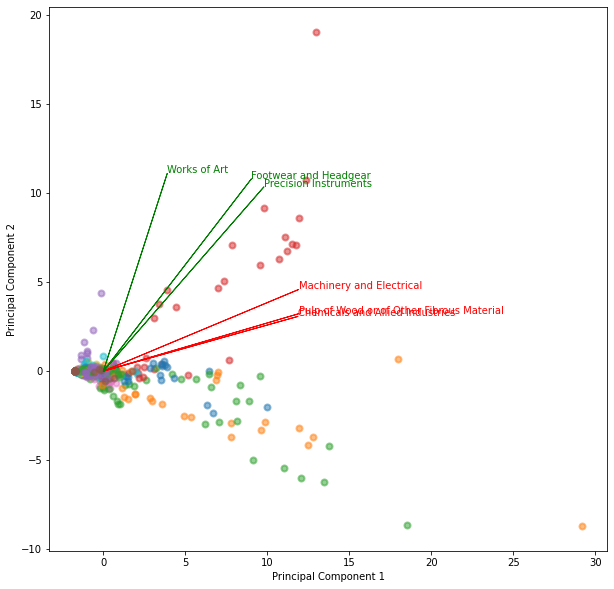

In [57]:
biplot_PCA_static(sector_features, 10, 1, 2, obs='reporter.ISO')

# ICA

In [58]:
features_data=sector_features

# Run PCA (standardize beforehand)
features_data_std = StandardScaler().fit_transform(features_data)
pca = PCA(n_components=3)
princ_comp = pca.fit_transform(features_data_std)

# Run ICA
features_data /= features_data.std(axis=0) # Standardize
ica = FastICA(n_components=3)
S_ = ica.fit_transform(features_data)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

In [59]:
cols = ['IC' + str(c+1) for c in np.arange(3)]
ica_loadings = pd.DataFrame(A_, 
                            columns=cols,
                            index=list(features_data.columns))
pca_loadings = pd.DataFrame(pca.components_.T, 
                            columns=cols,
                            index=list(features_data.columns))

In [60]:
ica_loadings.shape == pca_loadings.shape

True

In [61]:
S_.shape == princ_comp.shape

True

In [62]:
A_.shape == pca_loadings.shape

True

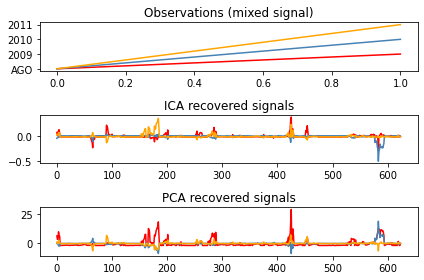

In [63]:
#features_data /= features_data.std(axis=0) # Standardize

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(features_data)  # Reconstruct signals

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(features_data)  # Reconstruct signals based on orthogonal components

# #############################################################################
# Plot results

plt.figure()

models = [features_data, S_, H]
names = ['Observations (mixed signal)',
         # 'True Sources',
         'ICA recovered signals', 
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(3, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()

In [64]:
for sig, color in zip(features_data.T, colors):
        print(sig)
        #plt.plot(sig, color=color)

('AGO', '2009')
('AGO', '2010')
('AGO', '2011')


In [65]:
#     # def biplot_PCA_static(features_data, nPC=2, firstPC=1, secondPC=2, obs='reporter.ISO', show_loadings=False):
# #     """Projects the data in the 2-dimensional space spanned by 2 principal components
# #     chosen by the user, along with a bi-plot of the top 3 loadings per PC, and colors
# #     by class label.
    
# #     Args:
# #         features_data: data-set of features
# #         nPC: number of principal components
# #         firstPC: integer denoting first principal component to plot in bi-plot
# #         secondPC: integer denoting second principal component to plot in bi-plot
# #         obs: string denoting index of class labels (in features_data)
# #         show_loadings: Boolean indicating whether PCA loadings should be displayed
# #     Returns:
# #         plot (static)
# #         pca_loadings (if show_loadings=True)
# #     """
# nPC=3
# firstPC=1
# secondPC=2
# obs='reporter.ISO'

# features_data=sector_features
# features_data /= features_data.std(axis=0) # Standardize
# ica = FastICA(n_components=3, random_state=np.random.RandomState(234))
# S_ = ica.fit_transform(features_data)  # Reconstruct signals
# A_ = ica.mixing_  # Get estimated mixing matrix

# # Run PCA (standardize beforehand)
# #features_data_std = StandardScaler().fit_transform(features_data)
# pca = PCA(n_components=nPC)
# princ_comp = pca.fit_transform(features_data_std)

# # Loadings
# cols = ['PC' + str(c+1) for c in np.arange(nPC)]
# pca_loadings = pd.DataFrame(pca.components_.T, 
# columns=cols,
# index=list(features_data.columns))

# ica_loadings = pd.DataFrame(A_, 
# columns=cols,
# index=list(features_data.columns))

# # Scores
# score_PC1 = princ_comp[:,firstPC-1]
# score_PC2 = princ_comp[:,secondPC-1]

# score_IC1 = S_[:,firstPC-1]
# score_IC2 = S_[:,secondPC-1]

# pca_scores = pd.DataFrame(princ_comp, 
# columns=cols)

# ica_scores = pd.DataFrame(S_, 
# columns=cols)

# # Return chosen PCs to plot
# PC1 = 'PC'+str(firstPC)
# PC2 = 'PC'+str(secondPC)

# # Top loadings (in absolute value)
# toploadings_PC1 = pca_loadings.nlargest(3, PC1)
# toploadings_PC2 = pca_loadings.nlargest(3, PC2)
# toploadings_PC1 = pca_loadings.apply(lambda x: abs(x)).sort_values(by=PC1).tail(3)
# toploadings_PC2 = pca_loadings.apply(lambda x: abs(x)).sort_values(by=PC2).tail(3)

# # Plot bi-plot
# plt.figure(figsize=(10,10))
# for i in range(toploadings_PC1.shape[0]):
#     plt.arrow(0, 0, 
#     toploadings_PC1[PC1][i]*max(score_PC1)*1.5, 
#     toploadings_PC1[PC2][i]*max(score_PC2)*1.5,
#     color='r', width=0.0005, head_width=0.0025)
#     plt.text(toploadings_PC1[PC1][i]*max(score_PC1)*1.5, 
#     toploadings_PC1[PC2][i]*max(score_PC2)*1.5,
#     toploadings_PC1.index.tolist()[i], color='r')
# for i in range(toploadings_PC2.shape[0]):
#     plt.arrow(0, 0, 
#     toploadings_PC2[PC1][i]*max(score_PC1)*1.5, 
#     toploadings_PC2[PC2][i]*max(score_PC2)*1.5,
#     color='g', width=0.0005, head_width=0.0025)
#     plt.text(toploadings_PC2[PC1][i]*max(score_PC1)*1.5, 
#     toploadings_PC2[PC2][i]*max(score_PC2)*1.5,
#     toploadings_PC2.index.tolist()[i], color='g')

#     plt.arrow(0, 0, 
#     toploadings_PC1[PC1][i]*max(score_PC1)*1.5, 
#     toploadings_PC1[PC2][i]*max(score_PC2)*1.5,

# # Extract class labels
# #     target = features_data.reset_index().set_index(obs).index.tolist()
# #     y = pd.Series(target).astype('category').cat.codes.values
# #     target_names = np.unique(target)
# #     rng = np.arange(0, len(target_names))

# # Add points
# #     for i, target_name in zip(list(rng), target_names):
# #          plt.scatter(princ_comp[y == i, firstPC-1], princ_comp[y == i, secondPC-1], 
# #                      alpha=.5, lw=2)
# #     plt.xlabel('Principal Component ' + str(firstPC))
# #     plt.ylabel('Principal Component ' + str(secondPC))

# #     for i, target_name in zip(list(rng), target_names):
# #         plt.scatter(S_[y == i, firstPC-1] , 
# #                     S_[y == i, secondPC-1] , 
# #                      alpha=.5, lw=2)
# plt.scatter(princ_comp[:, firstPC-1] / np.std(princ_comp[:, firstPC-1], axis=0), 
# princ_comp[:, secondPC-1] / np.std(princ_comp[:, secondPC-1], axis=0))
# plt.xlabel('Principal Component ' + str(firstPC))
# plt.ylabel('Principal Component ' + str(secondPC))

# plt.scatter(S_[:, firstPC-1] / np.std(S_[:, firstPC-1], axis=0), 
# S_[:, secondPC-1] / np.std(S_[:, secondPC-1], axis=0))
# plt.xlabel('Principal Component ' + str(firstPC))
# plt.ylabel('Principal Component ' + str(secondPC))

# #     if show_loadings:
# #         return pca_loadings

In [66]:
# def draw_vector(v0, v1, ax=None):
#     ax = ax or plt.gca()
#     arrowprops=dict(arrowstyle='->',
#                     linewidth=2,
#                     shrinkA=0, shrinkB=0)
#     ax.annotate('', v1, v0, arrowprops=arrowprops)
    
# sector_feat = sector_features[['Works of Art', 'Mineral Products']]
# features_data=sector_feat
# features_data /= features_data.std(axis=0) # Standardize

# X = features_data

# pca = PCA(n_components=2, whiten=True)
# pca.fit(X)

# fig, ax = plt.subplots(1, 2, figsize=(16, 6))
# fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

# # plot data
# ax[0].scatter(X.to_numpy()[:, 0], X.to_numpy()[:, 1], alpha=0.2)
# for length, vector in zip(pca.explained_variance_, pca.components_):
#     v = vector * 3 * np.sqrt(length)
#     draw_vector(pca.mean_, pca.mean_ + v, ax=ax[0])
# ax[0].axis('equal');
# ax[0].set(xlabel='x', ylabel='y', title='input')

# # plot principal components
# X_pca = pca.transform(X)
# ax[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2)
# draw_vector([0, 0], [0, 3], ax=ax[1])
# draw_vector([0, 0], [3, 0], ax=ax[1])
# ax[1].axis('equal')
# ax[1].set(xlabel='component 1', ylabel='component 2',
#           title='principal components',
#           xlim=(-5, 5), ylim=(-3, 3.1))

# # plt.scatter(sector_features.loc[:,'Machinery and Electrical'] / np.std(sector_features.loc[:,'Machinery and Electrical']),
# #             sector_features.loc[:,'Mineral Products'] / np.std(sector_features.loc[:,'Mineral Products']))
# #plt.scatter(partner_features.loc[:,'USA'], partner_features.loc[:,'CHN'])

In [67]:
features_data=sector_features
nPC=2
firstPC=1
secondPC=2
obs='reporter.ISO'

# Run PCA (standardize data beforehand)
features_data_std = StandardScaler().fit_transform(features_data)
pca = PCA(n_components=nPC)
princ_comp = pca.fit_transform(features_data_std)

# Extract PCA loadings
cols = ['PC' + str(c+1) for c in np.arange(nPC)]
pca_loadings = pd.DataFrame(pca.components_.T, 
                            columns=cols,
                            index=list(features_data.columns))

# Extract PCA scores
pca_scores = pd.DataFrame(princ_comp, 
                          columns=cols)
pca_scores[obs] = features_data.reset_index()[obs].values.tolist()
pca_scores['year'] = features_data.reset_index()['year'].values.tolist()

score_PC1 = princ_comp[:,firstPC-1]
score_PC2 = princ_comp[:,secondPC-1]

# Generate plot data
if obs == 'reporter.ISO':
    plot_data = pd.merge(pca_scores, obs_info, on=[obs, 'year'])
    color_obs = 'reporter'
    tooltip_obs = ['reporter', 'year', 'Income group (World Bank)', 'Country status (UN)']
else:
    plot_data = pca_scores
    color_obs = 'section'
    tooltip_obs = ['section', 'year']

# Return chosen PCs to plot
PC1 = 'PC'+str(firstPC)
PC2 = 'PC'+str(secondPC)

# Extract top loadings (in absolute value)
# TO DO: use dict to iterate over
toploadings_PC1 = pca_loadings.apply(lambda x: abs(x)).sort_values(by=PC1).tail(3)[[PC1, PC2]]
toploadings_PC2 = pca_loadings.apply(lambda x: abs(x)).sort_values(by=PC2).tail(3)[[PC1, PC2]]

originsPC1 = pd.DataFrame({'index':toploadings_PC1.index.tolist(), 
                           PC1: np.zeros(3), 
                           PC2:np.zeros(3)})
originsPC2 = pd.DataFrame({'index':toploadings_PC2.index.tolist(), 
                           PC1: np.zeros(3), 
                           PC2:np.zeros(3)})

toploadings_PC1 = pd.concat([toploadings_PC1.reset_index(), originsPC1], axis=0)
toploadings_PC2 = pd.concat([toploadings_PC2.reset_index(), originsPC2], axis=0)

toploadings_PC1[PC1] = toploadings_PC1[PC1]*max(score_PC1)*1.5
toploadings_PC1[PC2] = toploadings_PC1[PC2]*max(score_PC2)*1.5
toploadings_PC2[PC1] = toploadings_PC2[PC1]*max(score_PC1)*1.5
toploadings_PC2[PC2] = toploadings_PC2[PC2]*max(score_PC2)*1.5

# Project top 3 loadings over the space spanned by 2 principal components
lines = alt.Chart().mark_line().encode()
for color, i, dataset in zip(['#440154FF', '#21908CFF'], [0,1], [toploadings_PC1, toploadings_PC2]):
    lines[i] = alt.Chart(dataset).mark_line(color=color).encode(
    x= PC1 +':Q',
    y= PC2 +':Q',
    detail='index'
).properties(
    width=500,
    height=500
)

# Add labels to the loadings
text=alt.Chart().mark_text().encode()
for color, i, dataset in zip(['#440154FF', '#21908CFF'], [0, 1], [toploadings_PC1[0:3], toploadings_PC2[0:3]]):
    text[i] = alt.Chart(dataset).mark_text(
            align='left',
            baseline='bottom',
            color=color
        ).encode(
            x= PC1 +':Q',
            y= PC2 +':Q',
            text='index'
        )

# Scatter plot colored by observation class label
points = alt.Chart(plot_data).mark_circle(size=60).encode(
    x=alt.X(PC1, axis=alt.Axis(title='Principal Component ' + str(firstPC))),
    y=alt.X(PC2, axis=alt.Axis(title='Principal Component ' + str(secondPC))),
    color=alt.Color(color_obs, scale=alt.Scale(scheme='category20b'),
                   legend=alt.Legend(orient='right')),
    tooltip=tooltip_obs
).interactive()

# Bind it all together
chart = (points + lines[0] + lines[1] + text[0] + text[1])    
chart

alt.LayerChart(...)